# New CMD selection

Any star will have an expected position in the CMD given its bp_rp color and the absolute magnitude computed from the implied distance. This means that the position in the CMD will be physical only for stars that have specific absolute magnitude for the implied distane and effective temperature. 

The idea of this notebook is to test different classification criteria for these stars. To get an idea of the gaia CMD and were HVS should fall, I will first plot the CMD for stars with low extinction and well characterized parallaxes (stars within 200pc) and overplot HVS simulated using speedystar.

In [81]:
# imports 

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from astropy.io import fits
from astropy.table import Table, vstack
from astropy import units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord, Galactocentric, ICRS
from astropy.constants import kpc, au
from astropy.coordinates import CartesianRepresentation, CartesianDifferential
from astropy.coordinates.matrix_utilities import rotation_matrix, matrix_product, matrix_transpose
from numba import njit

import random
import healpy as hp

from matplotlib.gridspec import GridSpec
from scipy.optimize import minimize

In [2]:
# set up the plotting
# set font size
plt.rcParams.update({'font.size': 18})
# set the figure size
plt.rcParams.update({'figure.figsize': (10, 7)})
# set the font to latex
plt.rcParams.update({'text.usetex': True})

# set the path to save plots
plots_path = '/Users/mncavieres/Documents/2024-2/HVS/Plots/new_cmd'

In [3]:
# load gaia stars within 200pc. gaia archive is down for maintenance, so I will use sergeys system. 
#data_gaia = pd.read_feather('/Users/mncavieres/Documents/2024-2/HVS/Data/Gaia_tests/200pc/raw_gaia_catalog/3M_sources_goodruwe.feather')
data_gaia = Table.read('/Users/mncavieres/Documents/2024-2/HVS/Data/Gaia_tests/200pc/raw_gaia_catalog/has_rvs_200pc.fits')

In [4]:
# add some useful columns
data_gaia['bp_rp'] = data_gaia['phot_bp_mean_mag'] - data_gaia['phot_rp_mean_mag']
data_gaia['geometric_distance'] = 1000/data_gaia['parallax']
data_gaia['M_g'] = data_gaia['phot_g_mean_mag'] - 5*np.log10(data_gaia['geometric_distance']) + 5


In [5]:
simulated_catalog_f = Table.read('/Users/mncavieres/Documents/2024-2/HVS/Data/speedystar_catalogs/kappa_1.7_4.3_nocuts.fits')
# add some useful columns
simulated_catalog_f['bp_rp'] = simulated_catalog_f['Gaia_BP'] - simulated_catalog_f['Gaia_RP']
simulated_catalog_f['M_g'] = simulated_catalog_f['Gaia_G'] - 5*np.log10(simulated_catalog_f['dist']*1000) + 5

In [6]:
# drop nan values from astropy table
data_gaia = data_gaia.to_pandas().dropna(subset=['bp_rp', 'M_g'])

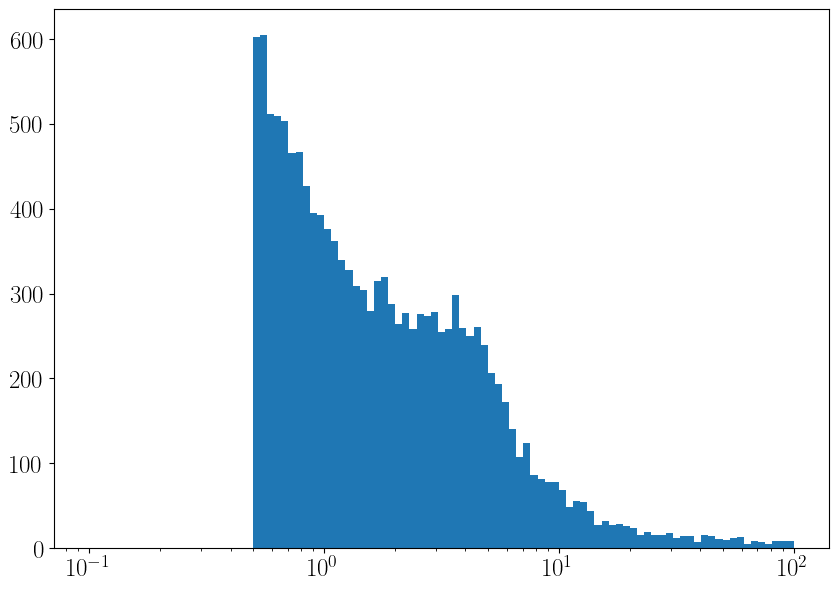

In [7]:
plt.hist(simulated_catalog_f['m'], bins=np.logspace(-1,2,100))
plt.xscale('log')
plt.show()

/var/folders/__/n140hqf972zfmtt1hs5ldglw0000gn/T/ipykernel_46511/3523487616.py:11: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


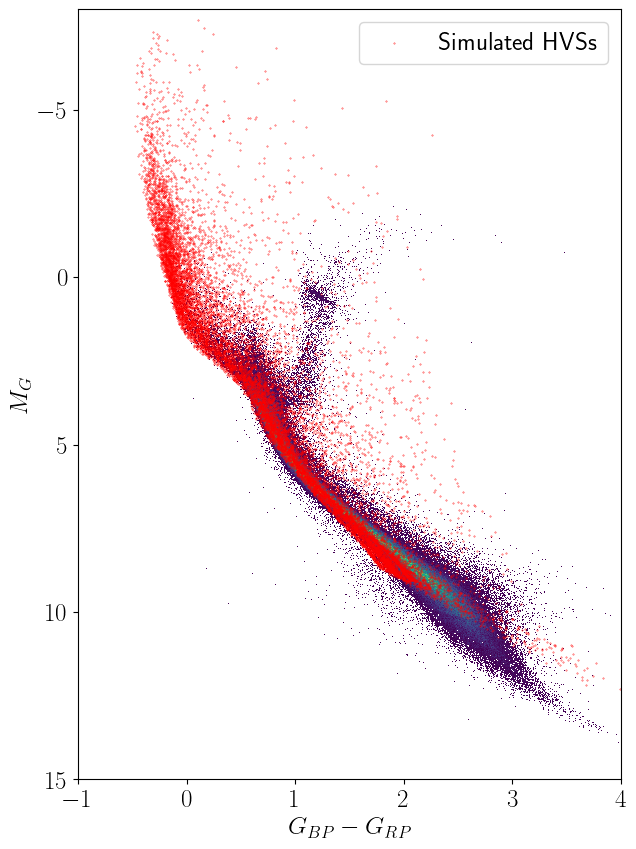

In [281]:

# using hist2d
# plot CMD
plt.figure(figsize=(7, 10))
plt.hist2d(data_gaia['bp_rp'], data_gaia['M_g'], label = 'Gaia < 200 pc', bins= 1000, cmin= 1)
plt.scatter(simulated_catalog_f['bp_rp'], simulated_catalog_f['M_g'], s=0.1, color='red', alpha=0.9, label='Simulated HVSs')
plt.gca().invert_yaxis()
plt.ylim(15, -8)
plt.xlim(-1, 4)
plt.xlabel('$G_{BP} - G_{RP}$')
plt.ylabel('$M_G$')
plt.legend()
plt.show()

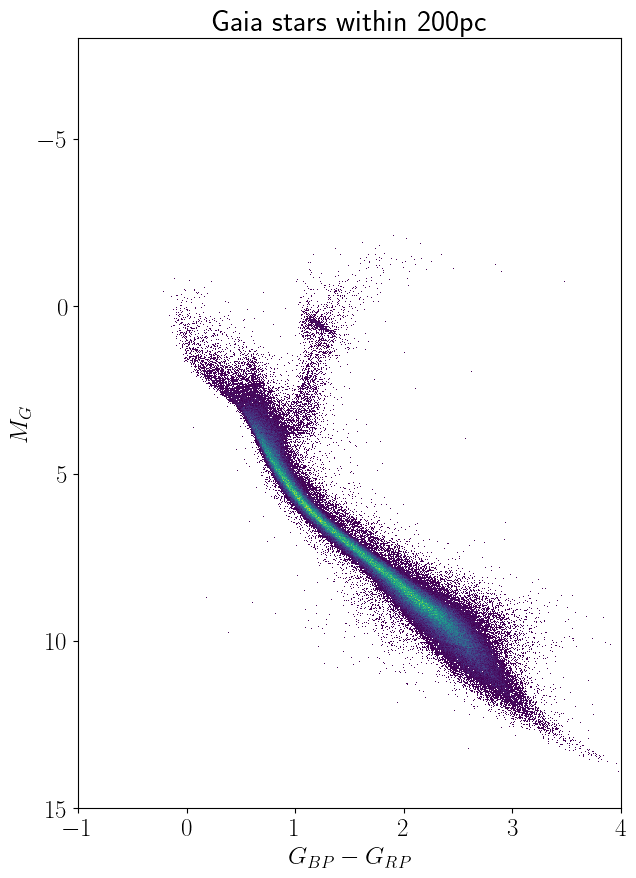

In [9]:

# using hist2d
# plot CMD
plt.figure(figsize=(7, 10))
plt.hist2d(data_gaia['bp_rp'], data_gaia['M_g'], label='Gaia stars', bins= 1000, cmin= 1)
#plt.scatter(simulated_catalog_f['bp_rp'], simulated_catalog_f['M_g'], s=0.1, color='red', alpha=0.9, label='Simulated HVSs')
plt.gca().invert_yaxis()
plt.ylim(15, -8)
plt.xlim(-1, 4)
plt.xlabel('$G_{BP} - G_{RP}$')
plt.ylabel('$M_G$')
plt.title('Gaia stars within 200pc')
plt.show()

# Construct training catalog

In [196]:
simulated_catalog_f = Table.read('/Users/mncavieres/Documents/2024-2/HVS/Data/speedystar_catalogs/kappa_1.7_4.3_nocuts.fits')
# add some useful columns
simulated_catalog_f['bp_rp'] = simulated_catalog_f['Gaia_BP'] - simulated_catalog_f['Gaia_RP']
simulated_catalog_f['M_g'] = simulated_catalog_f['Gaia_G'] - 5*np.log10(simulated_catalog_f['dist']*1000) + 5

In [197]:
# rename the simulated catalog columns to match the gaia catalog
simulated_catalog_gaia = simulated_catalog_f
simulated_catalog_gaia.rename_column('Gaia_G', 'phot_g_mean_mag')
simulated_catalog_gaia.rename_column('Gaia_BP', 'phot_bp_mean_mag')
simulated_catalog_gaia.rename_column('Gaia_RP', 'phot_rp_mean_mag')
simulated_catalog_gaia.rename_column('par', 'parallax')
simulated_catalog_gaia.rename_column('e_par', 'parallax_error')
simulated_catalog_gaia.rename_column('e_pmra', 'pmra_error')
simulated_catalog_gaia.rename_column('e_pmdec', 'pmdec_error')
simulated_catalog_gaia['parallax'] = 1/simulated_catalog_gaia['dist']
simulated_catalog_gaia['is_hvs'] = np.ones(len(simulated_catalog_gaia))


In [198]:
# merge with a large gaia catalog
data_gaia_big = pd.read_feather('/Users/mncavieres/Documents/2024-2/HVS/Data/Gaia_tests/200pc/raw_gaia_catalog/3M_sources_goodruwe.feather')
data_gaia_big['bp_rp'] = data_gaia_big['phot_bp_mean_mag'] - data_gaia_big['phot_rp_mean_mag']

In [199]:
# keep only common columns
simulated_catalog_gaia = simulated_catalog_gaia[['ra', 'dec', 'bp_rp', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'parallax', 'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'is_hvs']]
data_gaia_big = data_gaia_big[['ra', 'dec', 'bp_rp', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'parallax', 'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error']]
data_gaia_big['is_hvs'] = np.zeros(len(data_gaia_big))

# keep only 100000 stars from the big catalog
data_gaia_big = data_gaia_big.sample(n=100000)

# vstack the catalogs
data_gaia_big = data_gaia_big.dropna(subset=['bp_rp', 'phot_g_mean_mag'])
simulated_catalog_gaia = simulated_catalog_gaia.to_pandas().dropna(subset=['bp_rp', 'phot_g_mean_mag'])

# concatenate the catalogs
data_gaia_big = pd.concat([data_gaia_big, simulated_catalog_gaia])

## Compute implied radial velocity and parallax

In [200]:
# Add the path to the 'scripts' folder directly
sys.path.append('/Users/mncavieres/Documents/2024-2/HVS')


In [201]:

# Now you can import from the 'scripts' package
from scripts.implied_d_vr import *  # Or import any other module
from scripts.selections import *


In [202]:
data_gaia_big = implied_calculations(data_gaia_big)

In [203]:
# keep only positive implied parallaxes
data_gaia_big = data_gaia_big.loc[data_gaia_big['implied_parallax'] > 0]

In [204]:
# add extinction correction
data_gaia_big = extinction_correction(data_gaia_big)

In [205]:
# compute the implied absolute magnitude
data_gaia_big['implied_M_g'] = data_gaia_big['phot_g_mean_mag'] - 5*np.log10(1000/data_gaia_big['implied_parallax']) + 5
data_gaia_big['implied_M_g_corr'] = data_gaia_big['phot_g_mean_mag'] - 5*np.log10(1000/data_gaia_big['implied_parallax']) + 5

In [206]:
data_hvs = data_gaia_big.loc[data_gaia_big['is_hvs'] == 1]

/var/folders/__/n140hqf972zfmtt1hs5ldglw0000gn/T/ipykernel_46511/2413057580.py:11: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


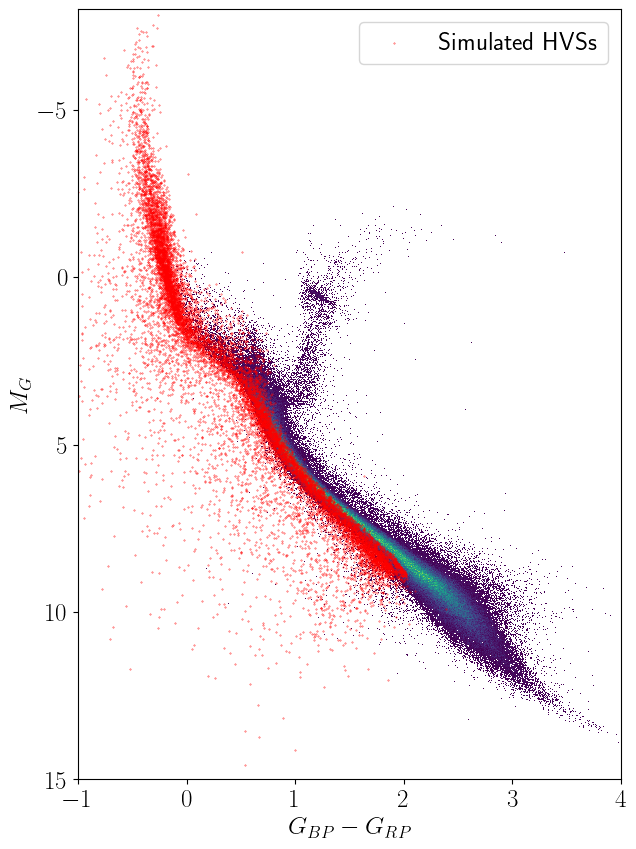

In [282]:

# using hist2d
# plot CMD
plt.figure(figsize=(7, 10))
plt.hist2d(data_gaia['bp_rp'], data_gaia['M_g'], label = 'Gaia < 200 pc', bins= 1000, cmin= 1)
plt.scatter(data_hvs['bp_rp_corr'], data_hvs['implied_M_g_corr'], s=0.1, color='red', alpha=0.9, label='Simulated HVSs')
plt.gca().invert_yaxis()
plt.ylim(15, -8)
plt.xlim(-1, 4)
plt.xlabel('$G_{BP} - G_{RP}$')
plt.ylabel('$M_G$')
plt.legend()
plt.show()

In [283]:
len(data_hvs)

12957

/var/folders/__/n140hqf972zfmtt1hs5ldglw0000gn/T/ipykernel_46511/307553308.py:9: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc ='upper right')


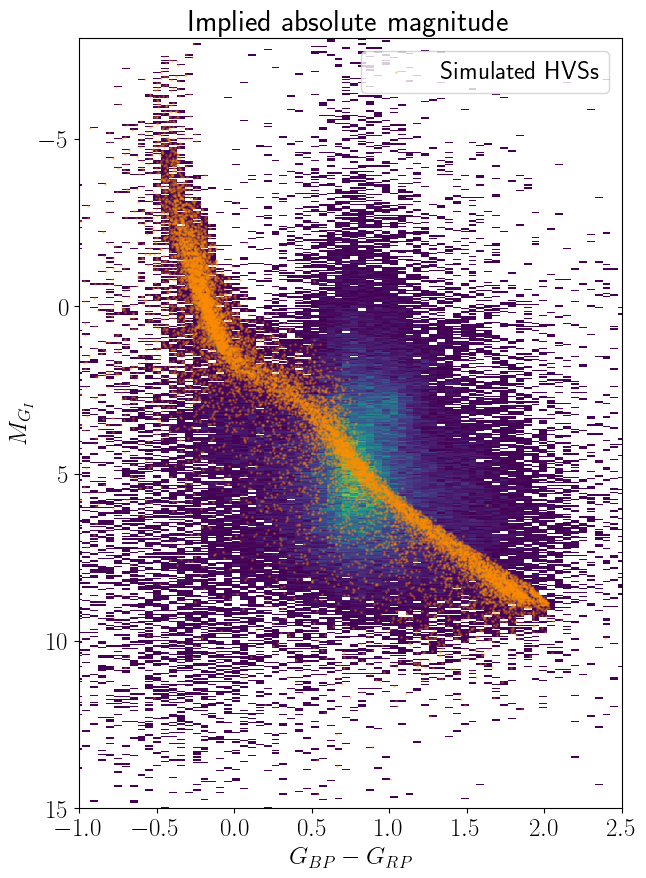

In [292]:
# plot the CMD
plt.figure(figsize=(7, 10))
plt.hist2d(data_gaia_big['bp_rp_corr'], data_gaia_big['implied_M_g_corr'], bins= 1000, cmin= 1, label='Gaia stars')
#sns.scatterplot(data=data_gaia_big, x='bp_rp', y='implied_M_g', hue='is_hvs', palette='coolwarm', s=1)
plt.scatter(data_hvs['bp_rp_corr'], data_hvs['implied_M_g_corr'], s=1, color='darkorange', alpha=0.3, label='Simulated HVSs')  
plt.gca().invert_yaxis()
plt.ylim(15, -8)
plt.xlim(-1, 2.5)
plt.legend(loc ='upper right')
plt.xlabel('$G_{BP} - G_{RP}$')
plt.ylabel('$M_{G_I}$')
plt.title('Implied absolute magnitude')
plt.show()

## How do we classify this:

I need a method that selects stars that are in the correct position in the CMD given their implied distances, observed magntiudes and colors. I need a way to test this, which could be using speedystar.

### Fit a polynomial to the main sequence and provide a specific width

The problem here is how can we decide on the specific population to use, we could base it up on the 3 star formation burst that took place in the galactic center. Then use isochrones for populations of those ages and metalicities, and a width given by the average error propagation from the implied distance to the implied absolute magnitude.

For this we first need to implement error propagation from the implied distance to the implied absolute magntiude, which will depend entirely on the proper motion uncertainties. This could be easy using the uncertainties package

In [130]:
from scipy.optimize import minimize
from astropy.stats import sigma_clip
from scipy.stats import binned_statistic

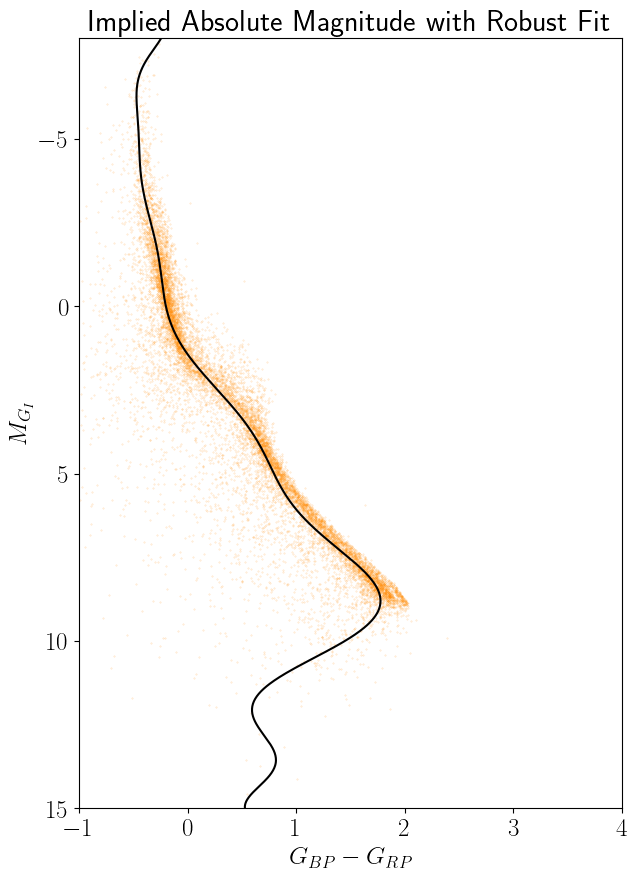

In [208]:


# Custom loss function: log(1 + abs(data - model) / (2 * sigma))
def custom_loss(coeffs, x, y, sigma=1.0):
    model = np.polyval(coeffs, x)
    residuals = y - model
    loss = np.log(1 + np.abs(residuals) / (2 * sigma))
    return np.sum(loss)

# Fit polynomial using scipy.optimize
def robust_polyfit(x, y, degree, sigma=1.0):
    # Initial guess for polynomial coefficients (from np.polyfit)
    initial_guess = np.polyfit(x, y, degree)
    
    # Minimize the custom loss function
    result = minimize(custom_loss, initial_guess, args=(x, y, sigma))
    
    return result.x  # Return optimized polynomial coefficients

# Iterate over the dataset, fitting the polynomial and removing outliers
data_hvs = data_gaia_big.loc[data_gaia_big['is_hvs'] == 1]
for i in range(10):
    # Fit a robust polynomial to the data
    polynomial_hvs_cmd = robust_polyfit(data_hvs['implied_M_g_corr'], data_hvs['bp_rp_corr'], degree=15, sigma=0.5)
    
    # Compute the residuals
    residuals = data_hvs['bp_rp_corr'] - np.polyval(polynomial_hvs_cmd, data_hvs['implied_M_g_corr'])
    
    # Remove outliers based on residual threshold
    data_hvs = data_hvs.loc[np.abs(residuals) < 0.5]



# Plot the result
data_hvs = data_gaia_big.loc[data_gaia_big['is_hvs'] == 1]
plt.figure(figsize=(7, 10))
plt.scatter(data_hvs['bp_rp_corr'], data_hvs['implied_M_g_corr'], s=0.1, color='darkorange', alpha=0.3)
x = np.linspace(data_hvs['implied_M_g_corr'].min(), data_hvs['implied_M_g_corr'].max(), 1000)
plt.plot(np.polyval(polynomial_hvs_cmd, x), x, color='black', label='Robust Polynomial Fit')
plt.gca().invert_yaxis()
plt.ylim(15, -8)
plt.xlim(-1, 4)
plt.xlabel('$G_{BP} - G_{RP}$')
plt.ylabel('$M_{G_I}$')
plt.title('Implied Absolute Magnitude with Robust Fit')
plt.show()


## Remove outliers before fitting:

In [209]:
# Sigma clipping function
def sigma_clip_bins(x, y, num_bins=20, sigma_threshold=3, max_iter=10, mean_tol=1e-6):
    # Define bin edges
    bin_edges = np.linspace(np.min(x), np.max(x), num_bins + 1)
    binned_data_x = []
    binned_data_y = []

    for i in range(num_bins):
        # Mask for current bin
        bin_mask = (x >= bin_edges[i]) & (x < bin_edges[i + 1])
        x_bin = x[bin_mask]
        y_bin = y[bin_mask]
        
        if len(y_bin) == 0:
            continue  # Skip empty bins
        
        iteration = 0
        mean_prev = np.inf

        while iteration < max_iter:
            mean_y = np.mean(y_bin)
            std_y = np.std(y_bin)
            # Identify outliers
            residuals = y_bin - mean_y
            mask = np.abs(residuals) <= sigma_threshold * std_y
            y_bin_new = y_bin[mask]
            x_bin_new = x_bin[mask]
            
            if len(y_bin_new) == len(y_bin):
                # No more outliers removed
                break
            
            # Check if mean has stabilized
            if np.abs(mean_prev - mean_y) < mean_tol:
                break
            
            y_bin = y_bin_new
            x_bin = x_bin_new
            mean_prev = mean_y
            iteration += 1

        binned_data_x.append(x_bin)
        binned_data_y.append(y_bin)

    # Combine data from all bins
    x_clipped = np.concatenate(binned_data_x)
    y_clipped = np.concatenate(binned_data_y)
    return x_clipped, y_clipped

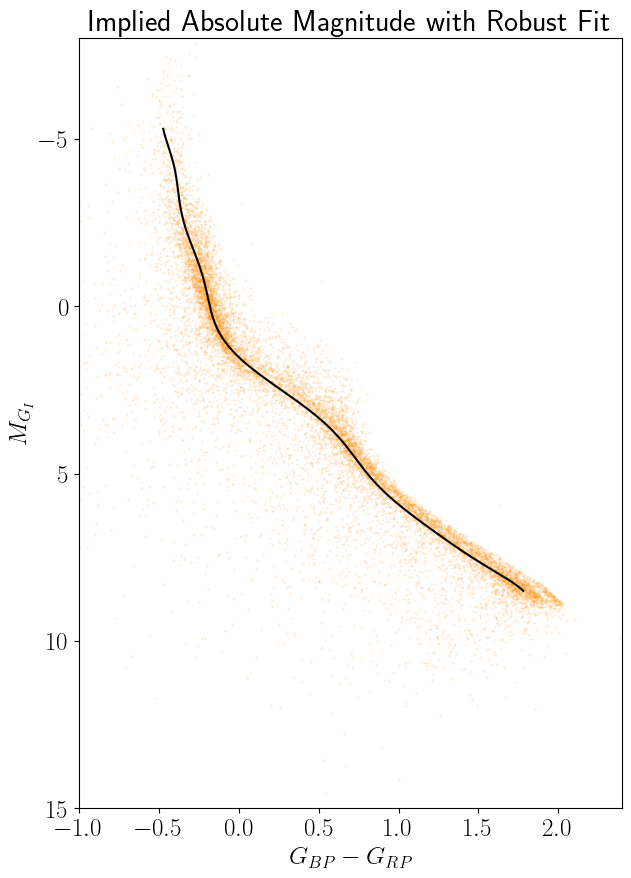

In [297]:
data_hvs = data_gaia_big.loc[data_gaia_big['is_hvs'] == 1]
data_hvs = data_hvs.loc[data_hvs['implied_M_g_corr'] < 10]
x_for_fit, y_for_fit = sigma_clip_bins(data_hvs['implied_M_g_corr'].values, data_hvs['bp_rp_corr'].values, num_bins=20, sigma_threshold=3, max_iter=1000, mean_tol=1e-6)
    
# Fit a robust polynomial to the data
polynomial_hvs_cmd = robust_polyfit(x_for_fit, y_for_fit, degree=15, sigma=0.5)
    

# Plot the result
data_hvs = data_gaia_big.loc[data_gaia_big['is_hvs'] == 1]
plt.figure(figsize=(7, 10))
plt.scatter(data_hvs['bp_rp_corr'], data_hvs['implied_M_g_corr'], s=0.1, color='darkorange', alpha=0.3)
x = np.linspace(-5.3, 8.5, 1000)

#x = np.linspace(data_hvs['implied_M_g_corr'].min(), data_hvs['implied_M_g_corr'].max(), 1000)
plt.plot(np.polyval(polynomial_hvs_cmd, x), x, color='black', label='Robust Polynomial Fit')
plt.gca().invert_yaxis()
plt.ylim(15, -8)
plt.xlim(-1, 2.4)
plt.xlabel('$G_{BP} - G_{RP}$')
plt.ylabel('$M_{G_I}$')
plt.title('Implied Absolute Magnitude with Robust Fit')
plt.show()

## Filter data using the fit

In [211]:



# implement filtering that uses this polynomial to select sources that are within a certain distance form the polynomial
def filter_within_width(df, p, x_col, y_col, width):
    """
    Fit an n-degree polynomial, and filter rows that are 
    within a specified width from the fitted polynomial, perpendicular to the polynomial.

    :param df: DataFrame containing the data.
    :param x_col: Column name for x values.
    :param y_col: Column name for y values.
    :param n: Degree of the polynomial.
    :param width: Width for filtering.
    :return: Tuple containing the filtered DataFrame and polynomial function.
    """
    p = np.poly1d(p)

    # Calculate the polynomial's derivative
    p_prime = p.deriv(m= 1)

    # 2. Compute the predicted y value and slope (tangent) for each x-coordinate
    df['predicted_y'] = p(df[x_col])
    df['slope'] = p_prime(df[x_col])

    # 3. Compute the perpendicular distance from each point to the polynomial
    df['distance'] = np.abs(df[y_col] - df['predicted_y'] - df['slope'] * (df[x_col] - df[x_col])) / np.sqrt(df['slope']**2 + 1)

    # 4. Filter rows that are within the width from the fitted polynomial.
    within_width_df = df[df['distance'] <= width]

    # 5. Filter rows that are within the color range we want
    #within_color_up = within_width_df[within_width_df[x_col] <= 1]
    #within_width_down = within_color_up[within_color_up[x_col] >= 0.7]

    #return (within_width_down.drop(columns=['predicted_y', 'slope', 'distance']), p)
    return within_width_df.drop(columns=['predicted_y', 'slope', 'distance'])


def filter_within_sigma(df, x_col, y_col, p, bins, n_std):
    """
    Fit an n-degree polynomial, bin the data, and filter rows that are 
    within n_std sigma from the fitted polynomial.

    :param df: DataFrame containing the data.
    :param x_col: Column name for x values.
    :param y_col: Column name for y values.
    :param n: Degree of the polynomial.
    :param bins: Number of bins or explicit bin edges.
    :param n_std: Sigma value to define selection limit.
    :return: Tuple containing the filtered DataFrame, polynomial function, 
             bin midpoints, and bin standard deviations.
    """
    p = np.poly1d(p)
    
    # 2. Bin the sequence on the X-axis.
    df['bin'] = pd.cut(df[x_col], bins=bins, labels=False)
    df['predicted_y'] = p(df[x_col])

    # 3. For each bin, compute the standard deviation and bin midpoint.
    bin_group = df.groupby('bin')
    bin_std = bin_group[y_col].std()
    bin_midpoints = bin_group[x_col].mean()

    # 4. Filter rows that are within n_std sigma from the fitted polynomial.
    within_sigma_df = df[np.abs(df[y_col] - df['predicted_y']) <= df['bin'].map(bin_std)*n_std]

    return (within_sigma_df.drop(columns=['bin', 'predicted_y']), p, bin_midpoints.values, bin_std.values)

In [212]:
filtered_objects, _, bins, std_bins = filter_within_sigma(df = data_gaia_big, x_col= 'implied_M_g_corr',y_col= 'bp_rp_corr',
                                        p=  polynomial_hvs_cmd, bins= 40, n_std= 0.3)
filtered_objects = filtered_objects.loc[filtered_objects['implied_M_g_corr'] < 9]

#### Filter using the sigma values of the distribution

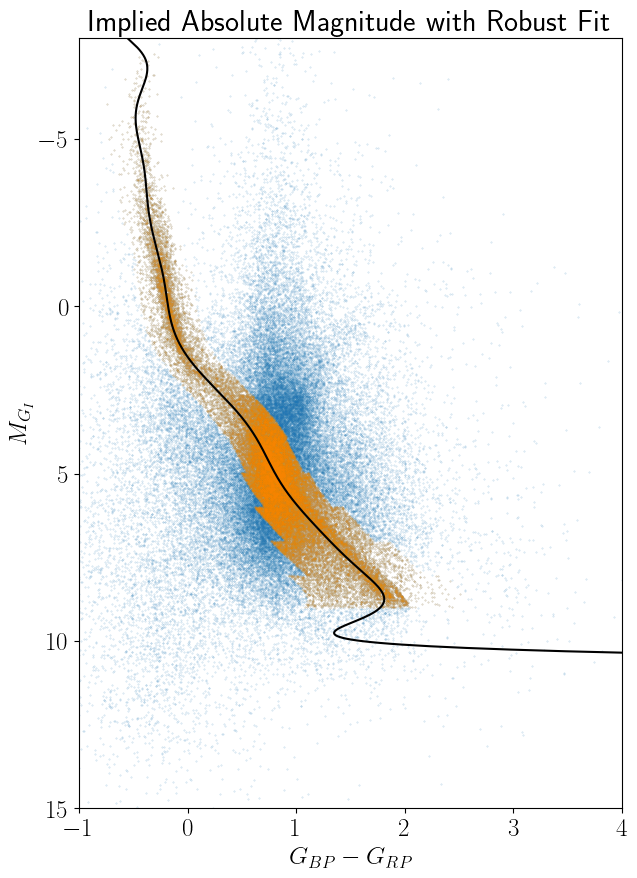

In [213]:

# Plot the result
data_hvs = data_gaia_big.loc[data_gaia_big['is_hvs'] == 1]
plt.figure(figsize=(7, 10))
#plt.scatter(data_hvs['bp_rp'], data_hvs['implied_M_g'], s=0.1, color='darkorange', alpha=0.3)
plt.scatter(data_gaia_big['bp_rp_corr'], data_gaia_big['implied_M_g_corr'], s=0.1, alpha=0.3)
plt.scatter(filtered_objects['bp_rp_corr'], filtered_objects['implied_M_g_corr'], s=0.1, color='darkorange', alpha=0.3)
x = np.linspace(data_hvs['implied_M_g_corr'].min(), data_hvs['implied_M_g_corr'].max(), 1000)
plt.plot(np.polyval(polynomial_hvs_cmd, x), x, color='black', label='Robust Polynomial Fit')

plt.gca().invert_yaxis()
plt.ylim(15, -8)
plt.xlim(-1, 4)
plt.xlabel('$G_{BP} - G_{RP}$')
plt.ylabel('$M_{G_I}$')
plt.title('Implied Absolute Magnitude with Robust Fit')
plt.show()


### Filter using distance from polynomial

In principle this distance cut from the polynomial should be informed by the overall error in the positon of a star in the CMD, this means taking into account the error in the color from the unkown distance in line of sight, and therefore the unkown reddening. Same thing for the implied absolute magntiude which has an error from the extinction and from the propagation of the implied distance uncertainty

In [214]:
filtered_objects = filter_within_width(df = data_gaia_big, x_col= 'implied_M_g_corr',y_col= 'bp_rp_corr',
                                        p=  polynomial_hvs_cmd, width= 0.2)
filtered_objects = filtered_objects.loc[filtered_objects['implied_M_g_corr'] < 9]

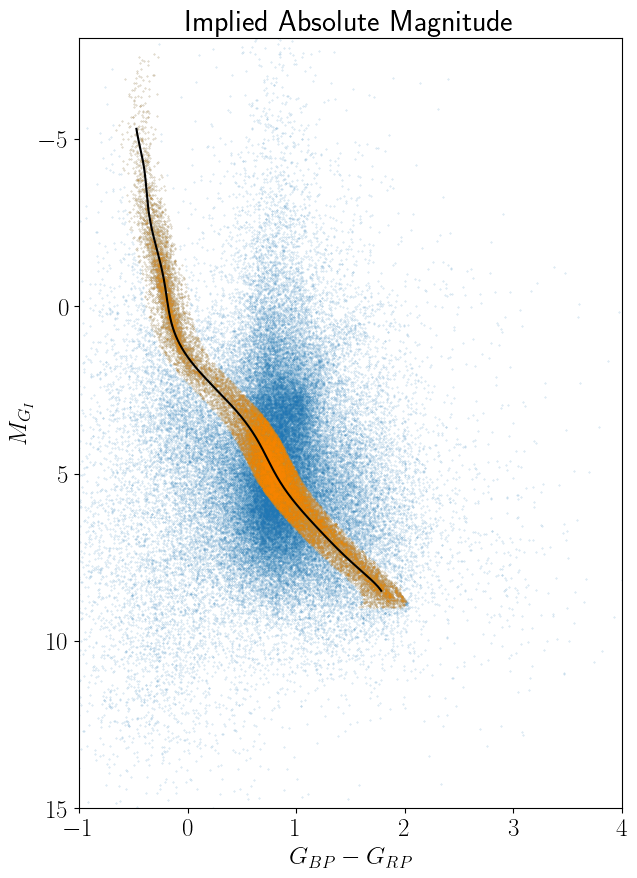

In [300]:

# Plot the result
data_hvs = data_gaia_big.loc[data_gaia_big['is_hvs'] == 1]
plt.figure(figsize=(7, 10))
#plt.scatter(data_hvs['bp_rp'], data_hvs['implied_M_g'], s=0.1, color='darkorange', alpha=0.3)
plt.scatter(data_gaia_big['bp_rp_corr'], data_gaia_big['implied_M_g_corr'], s=0.1, alpha=0.3)
plt.scatter(filtered_objects['bp_rp_corr'], filtered_objects['implied_M_g_corr'], s=0.1, color='darkorange', alpha=0.3)
#x = np.linspace(data_hvs['implied_M_g_corr'].min(), data_hvs['implied_M_g_corr'].max(), 1000)
x = np.linspace(-5.3, 8.5, 1000)
plt.plot(np.polyval(polynomial_hvs_cmd, x), x, color='black', label='Robust Polynomial Fit')

plt.gca().invert_yaxis()
plt.ylim(15, -8)
plt.xlim(-1, 4)
plt.xlabel('$G_{BP} - G_{RP}$')
plt.ylabel('$M_{G_I}$')
plt.title('Implied Absolute Magnitude')
plt.show()


In [227]:
precision = len(filtered_objects.loc[filtered_objects['is_hvs'] == 1])/len(filtered_objects)#.loc[filtered_objects['is_hvs'] == 0])
completeness = len(filtered_objects.loc[filtered_objects['is_hvs'] == 1])/len(data_hvs)

print('Using the fitting method, the precision is:', precision)
print('Using the fitting method, the completeness is:', completeness)

Using the fitting method, the precision is: 0.37107547237203986
Using the fitting method, the completeness is: 0.8018059736050012


### Taking out most of the contamination based on the bp_rp color

In [230]:
color_filtered_objects = filtered_objects.loc[(filtered_objects['bp_rp_corr']<0.5 )| (filtered_objects['bp_rp_corr']>1.2)]
precision = len(color_filtered_objects.loc[color_filtered_objects['is_hvs'] == 1])/len(color_filtered_objects) #.loc[color_filtered_objects['is_hvs'] == 0])
completeness = len(color_filtered_objects.loc[color_filtered_objects['is_hvs'] == 1])/len(data_hvs)

print('Using the fitting method, the precision is:', precision)
print('Using the fitting method, the completeness is:', completeness)

Using the fitting method, the precision is: 0.7402216118950659
Using the fitting method, the completeness is: 0.6032260554140619


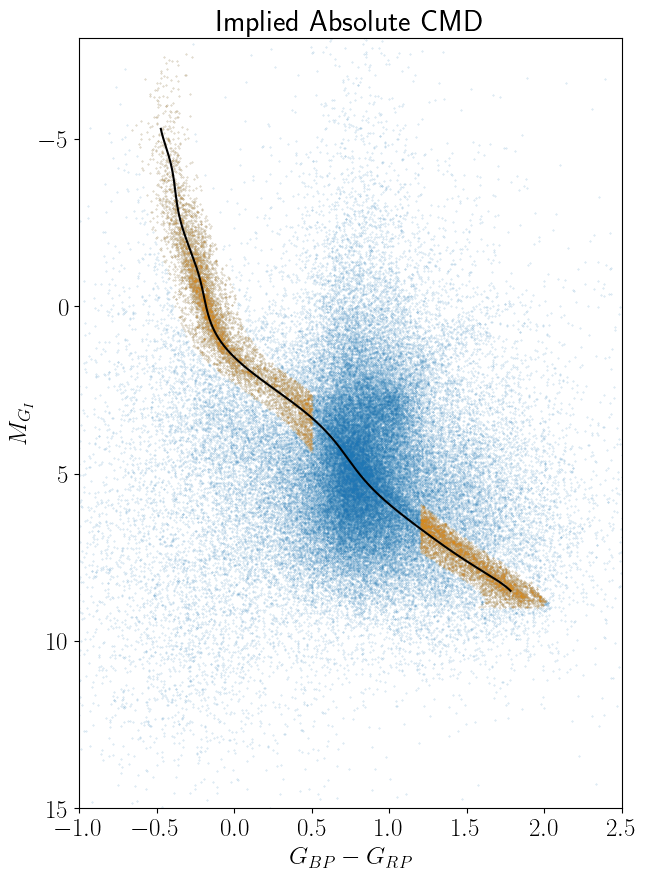

In [302]:

# Plot the result
data_hvs = data_gaia_big.loc[data_gaia_big['is_hvs'] == 1]
plt.figure(figsize=(7, 10))
#plt.scatter(data_hvs['bp_rp'], data_hvs['implied_M_g'], s=0.1, color='darkorange', alpha=0.3)
plt.scatter(data_gaia_big['bp_rp_corr'], data_gaia_big['implied_M_g_corr'], s=0.1, alpha=0.3)
plt.scatter(color_filtered_objects['bp_rp_corr'], color_filtered_objects['implied_M_g_corr'], s=0.1, color='darkorange', alpha=0.3)
#x = np.linspace(data_hvs['implied_M_g_corr'].min(), data_hvs['implied_M_g_corr'].max(), 1000)
x = np.linspace(-5.3, 8.5, 1000)
plt.plot(np.polyval(polynomial_hvs_cmd, x), x, color='black', label='Robust Polynomial Fit')

plt.gca().invert_yaxis()
plt.ylim(15, -8)
plt.xlim(-1, 2.5)
plt.xlabel('$G_{BP} - G_{RP}$')
plt.ylabel('$M_{G_I}$')
plt.title('Implied Absolute CMD')
plt.show()


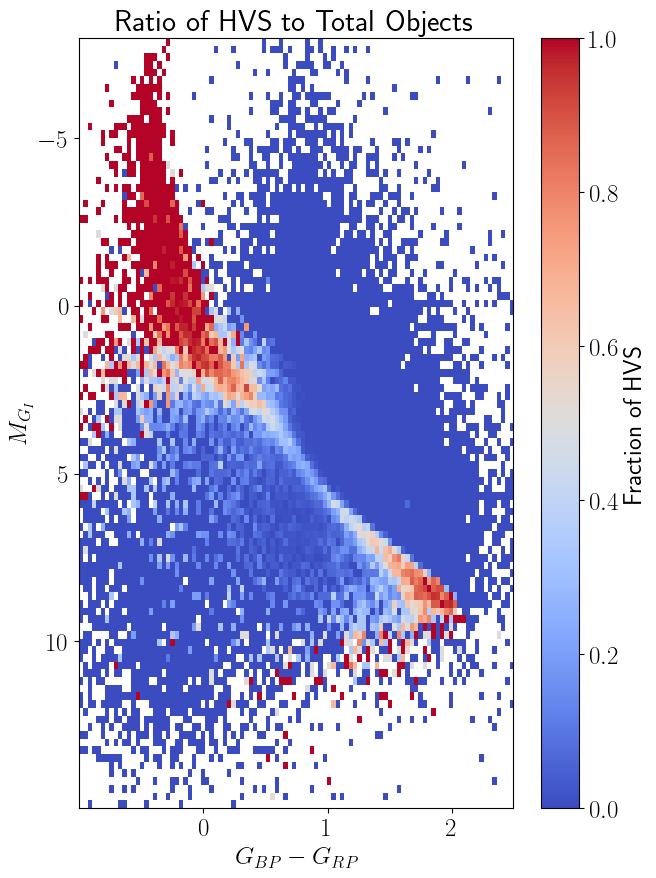

In [264]:
# make a 2dhist that shows the radio of objects that are hvs to the total number of objects in each bin in the data_gaia_big catalog using the is_hvs column


# Extract necessary columns
data_gaia_big_for_hist = data_gaia_big.loc[(data_gaia_big['implied_M_g_corr'] < 15) 
                                           & (data_gaia_big['implied_M_g_corr'] > -8)
                                           & (data_gaia_big['bp_rp_corr'] < 2.5) 
                                           & (data_gaia_big['bp_rp_corr'] > -1)]
x = data_gaia_big_for_hist['bp_rp_corr'].values
y = data_gaia_big_for_hist['implied_M_g_corr'].values
is_hvs = data_gaia_big_for_hist['is_hvs'].values

# Define bin edges for X (bp_rp_corr) and Y (implied_M_g_corr)
num_bins_x = 100  # Adjust the number of bins as needed
num_bins_y = 100  # Adjust the number of bins as needed

x_bins = np.linspace(np.min(x), np.max(x), num_bins_x + 1)
y_bins = np.linspace(np.min(y), np.max(y), num_bins_y + 1)

# 2D histogram of total objects
total_hist, _, _ = np.histogram2d(x, y, bins=[x_bins, y_bins])

# 2D histogram of high-velocity stars (HVS)
hvs_hist, _, _ = np.histogram2d(x[is_hvs == 1], y[is_hvs == 1], bins=[x_bins, y_bins])

# Avoid division by zero
with np.errstate(divide='ignore', invalid='ignore'):
    ratio_hist = np.divide(hvs_hist, total_hist)
    ratio_hist[total_hist == 0] = np.nan  # Set bins with no total objects to NaN

# Plot the 2D histogram
plt.figure(figsize=(7, 10))
plt.imshow(ratio_hist.T, origin='lower', aspect='auto',
           extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]],
           cmap='coolwarm', vmin=0, vmax=1)
plt.gca().invert_yaxis()
plt.colorbar(label='Fraction of HVS')
plt.xlabel('$G_{BP} - G_{RP}$')
plt.ylabel('$M_{G_I}$')
plt.title('Ratio of HVS to Total Objects')
plt.show()



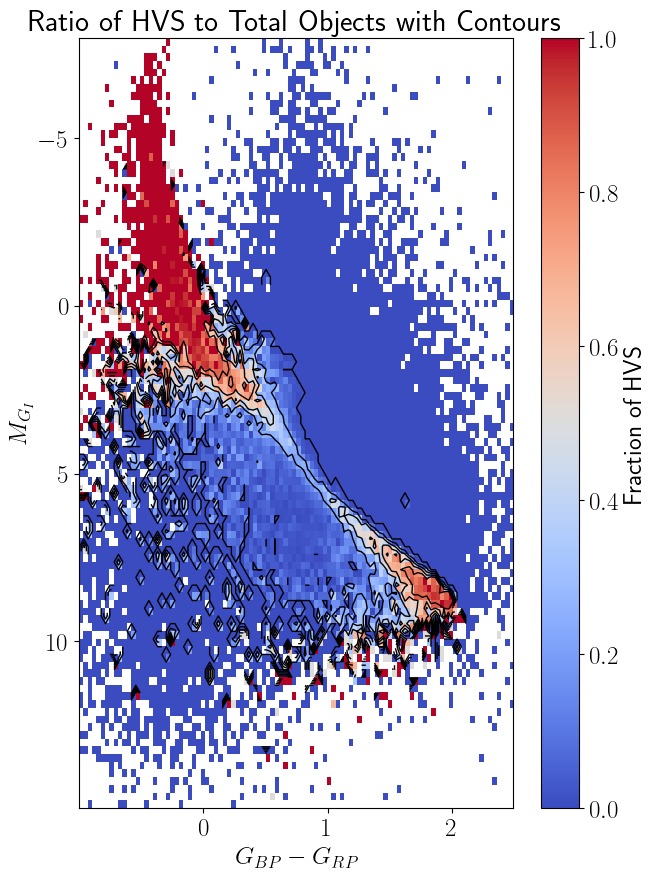

In [265]:
plt.figure(figsize=(7, 10))

# Plot the 2D histogram
plt.imshow(ratio_hist.T, origin='lower', aspect='auto',
           extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]],
           cmap='coolwarm', vmin=0, vmax=1)
plt.colorbar(label='Fraction of HVS')

# Add contours for the ratio values
# Define levels for contour lines, for example: [0.1, 0.3, 0.5, 0.7, 0.9]
contour_levels = np.linspace(0, 1, 6)  # 6 levels from 0 to 1

# Generate contour plot based on the ratio histogram
X, Y = np.meshgrid(x_bins[:-1], y_bins[:-1])  # Use bin edges for meshgrid
plt.contour(X, Y, ratio_hist.T, levels=contour_levels, colors='black', linewidths=1)

# Adjust the plot
plt.gca().invert_yaxis()
plt.xlabel('$G_{BP} - G_{RP}$')
plt.ylabel('$M_{G_I}$')
plt.title('Ratio of HVS to Total Objects with Contours')
plt.show()

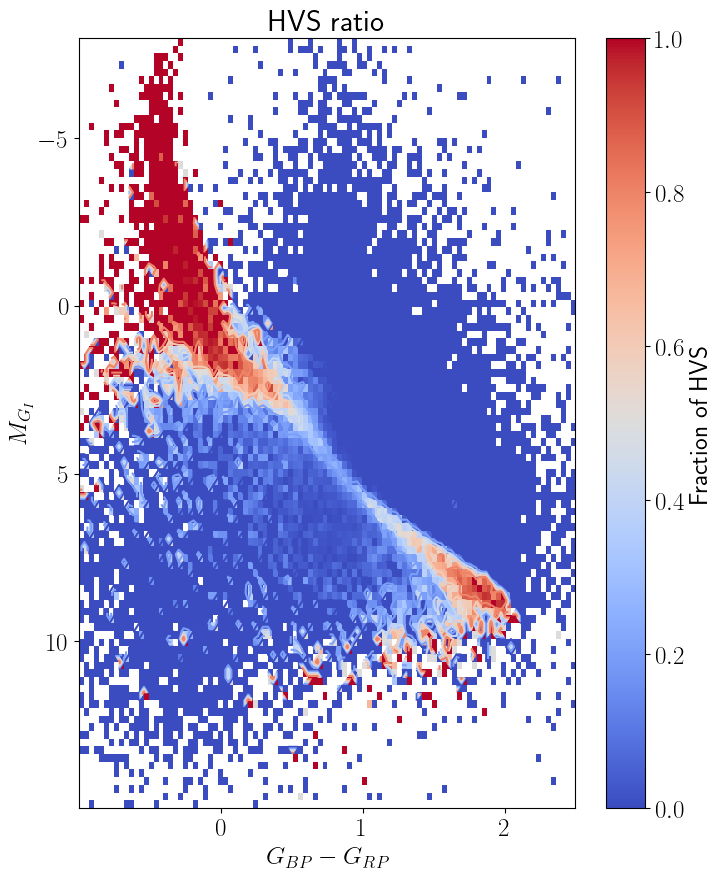

In [266]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming ratio_hist, x_bins, and y_bins are already computed as in the previous implementation

# Create figure
plt.figure(figsize=(8, 10))

# Plot the 2D histogram
im = plt.imshow(ratio_hist.T, origin='lower', aspect='auto',
                extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]],
                cmap='coolwarm', vmin=0, vmax=1)
cbar_img= plt.colorbar(label='Fraction of HVS')

# Add colored contours
contour_levels = np.linspace(0, 1, 6)  # Define levels for the contour

# Generate the contour plot, using the same colormap as the heatmap
X, Y = np.meshgrid(x_bins[:-1], y_bins[:-1])  # Use bin edges for meshgrid
contour = plt.contour(X, Y, ratio_hist.T, levels=contour_levels,
                      cmap='coolwarm', vmin=0, vmax=1)

# Add a colorbar for the contours (optional, if you want a separate colorbar)
#plt.colorbar(contour, label='Contour Levels')

# Adjust the plot
plt.gca().invert_yaxis()
plt.xlabel('$G_{BP} - G_{RP}$')
plt.ylabel('$M_{G_I}$')
plt.title('HVS ratio')

plt.show()


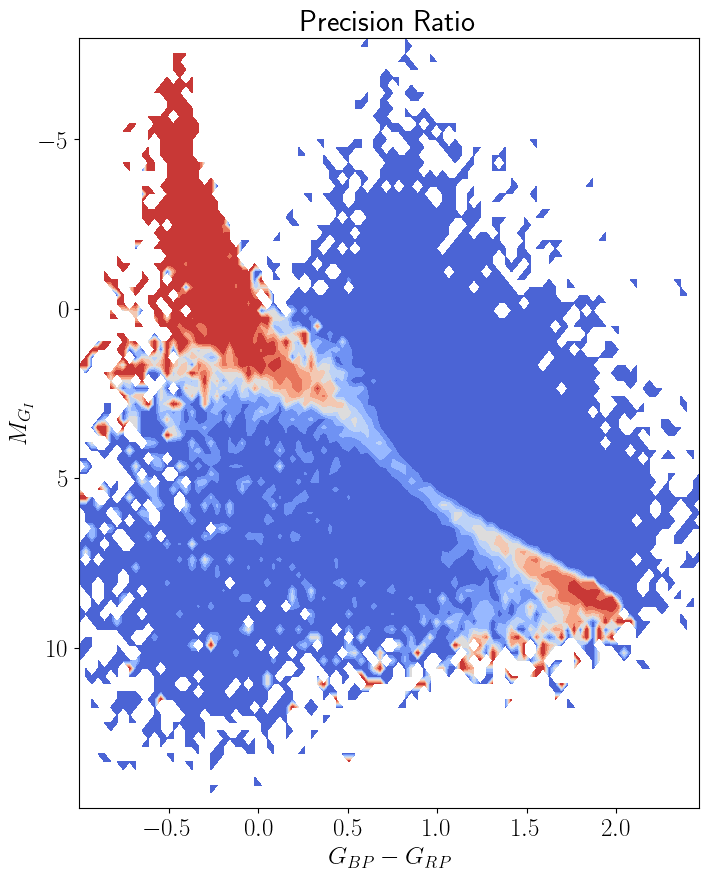

In [267]:
# Create figure
plt.figure(figsize=(8, 10))

# Define levels for the contour (for example, 6 levels from 0 to 1)
contour_levels = np.linspace(0, 1, 10)

# Generate the filled contour plot based on the ratio histogram
X, Y = np.meshgrid(x_bins[:-1], y_bins[:-1])  # Use bin edges for meshgrid
contour_filled = plt.contourf(X, Y, ratio_hist.T, levels=contour_levels, cmap='coolwarm', vmin=0, vmax=1)

# Add a colorbar to show the values represented by the contours
#plt.colorbar(contour_filled, label='Fraction of HVS')

# Adjust the plot
plt.gca().invert_yaxis()
plt.xlabel('$G_{BP} - G_{RP}$')
plt.ylabel('$M_{G_I}$')
plt.title('Precision Ratio')

plt.show()

In [258]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors


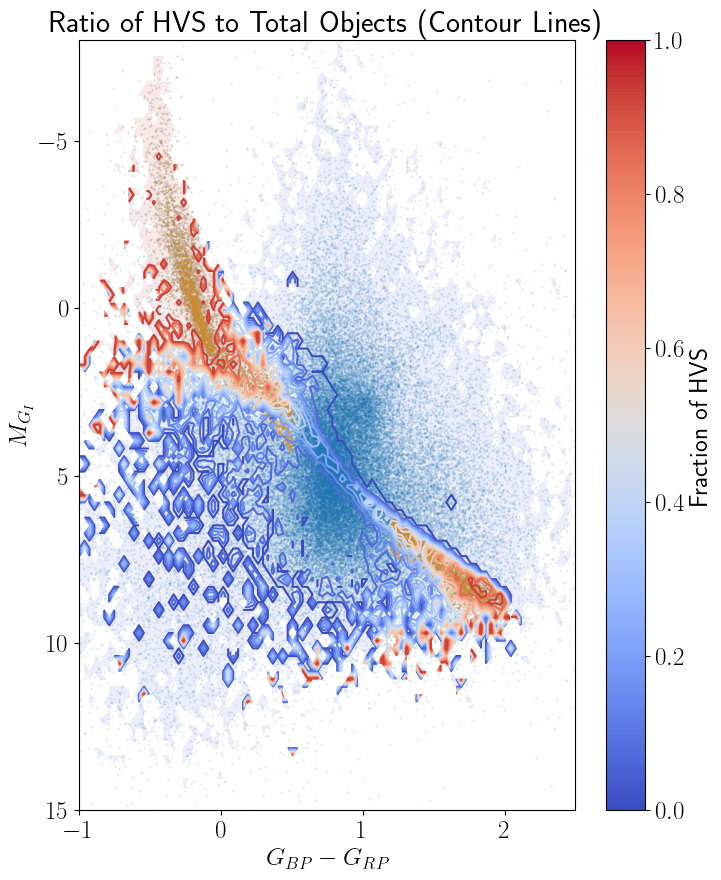

In [270]:
# Create figure
plt.figure(figsize=(8, 10))

# Define levels for the contour
contour_levels = np.linspace(0, 1, 15)

# Generate the contour plot with only lines (no filling)
X, Y = np.meshgrid(x_bins[:-1], y_bins[:-1])  # Use bin edges for meshgrid
contour_lines = plt.contour(X, Y, ratio_hist.T, levels=contour_levels, cmap='coolwarm', vmin=0, vmax=1)

contour_filled_2 = plt.contourf(X, Y, ratio_hist.T, levels=contour_levels, cmap='coolwarm', vmin=0, vmax=1, alpha = 0.1)

# Create a continuous colorbar based on the contour levels
# Create a normalizer to map the contour levels to colors
norm = mcolors.Normalize(vmin=0, vmax=1)

# Create a scalar mappable for the colorbar without displaying filled contours
sm = cm.ScalarMappable(norm=norm, cmap='coolwarm')

# Add a colorbar based on the scalar mappable
plt.colorbar(sm, label='Fraction of HVS', ax=plt.gca())


plt.scatter(data_gaia_big['bp_rp_corr'], data_gaia_big['implied_M_g_corr'], s=0.1, alpha=0.3)
plt.scatter(color_filtered_objects['bp_rp_corr'], color_filtered_objects['implied_M_g_corr'], s=0.1, color='darkorange', alpha=0.3)

# Adjust the plot
plt.gca().invert_yaxis()
plt.xlabel('$G_{BP} - G_{RP}$')
plt.ylabel('$M_{G_I}$')
plt.ylim(15, -8)
plt.xlim(-1, 2.5)
plt.title('Ratio of HVS to Total Objects (Contour Lines)')

plt.show()

### We could use this contours to filter the data

In [271]:

from matplotlib.path import Path

def filter_points_within_contour(contour_lines, df, x_col, y_col, level=None):
    """
    Filters a DataFrame to include only points within a specified contour level.

    Parameters:
        contour_lines: QuadContourSet object from plt.contour.
        df: pandas DataFrame containing the data points.
        x_col: Name of the column in df representing x-values.
        y_col: Name of the column in df representing y-values.
        level: The contour level to use for filtering. Defaults to the maximum level.

    Returns:
        filtered_df: DataFrame containing only points within the specified contour.
    """
    # Determine the contour level to use
    if level is None:
        level = np.max(contour_lines.levels)
    
    # Find the index of the specified level
    try:
        level_idx = np.where(contour_lines.levels == level)[0][0]
    except IndexError:
        raise ValueError(f"Level {level} is not in the contour levels.")
    
    # Get the collections of LineCollections at the specified level
    collection = contour_lines.collections[level_idx]
    
    # Get all the paths (contours) at this level
    paths = []
    for path in collection.get_paths():
        # For each sub-path in the path (in case of discontinuous contours)
        vertices = path.vertices
        codes = path.codes
        if codes is None:
            # Simple path
            paths.append(Path(vertices))
        else:
            # Compound path
            paths.append(Path(vertices, codes))
    
    # Prepare the points to test
    points = df[[x_col, y_col]].values
    
    # Initialize a mask of False
    mask = np.zeros(len(df), dtype=bool)
    
    # Check each path and update the mask
    for path in paths:
        mask |= path.contains_points(points)
    
    # Filter the DataFrame
    filtered_df = df[mask].copy()
    
    return filtered_df


In [303]:
contour_lines.levels[-2]

np.float64(0.9285714285714285)

In [279]:
# Use the function to filter points within the highest contour level
filtered_df = filter_points_within_contour(
    contour_lines=contour_lines,
    df=color_filtered_objects,
    x_col='bp_rp_corr',
    y_col='implied_M_g_corr',
    level=contour_lines.levels[-2]
)

# Now, filtered_df contains only the points within the specified contour
print(f"Total points before filtering: {len(color_filtered_objects)}")
print(f"Total points after filtering: {len(filtered_df)}")
print(f"The precision is: {len(filtered_df.loc[filtered_df['is_hvs'] == 1])/len(filtered_df)}")
print(f"The completeness is: {len(filtered_df.loc[filtered_df['is_hvs'] == 1])/len(data_hvs)}")

Total points before filtering: 10559
Total points after filtering: 3274
The precision is: 0.9789248625534515
The completeness is: 0.24735664119780815


/var/folders/__/n140hqf972zfmtt1hs5ldglw0000gn/T/ipykernel_46511/2810476252.py:28: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  collection = contour_lines.collections[level_idx]


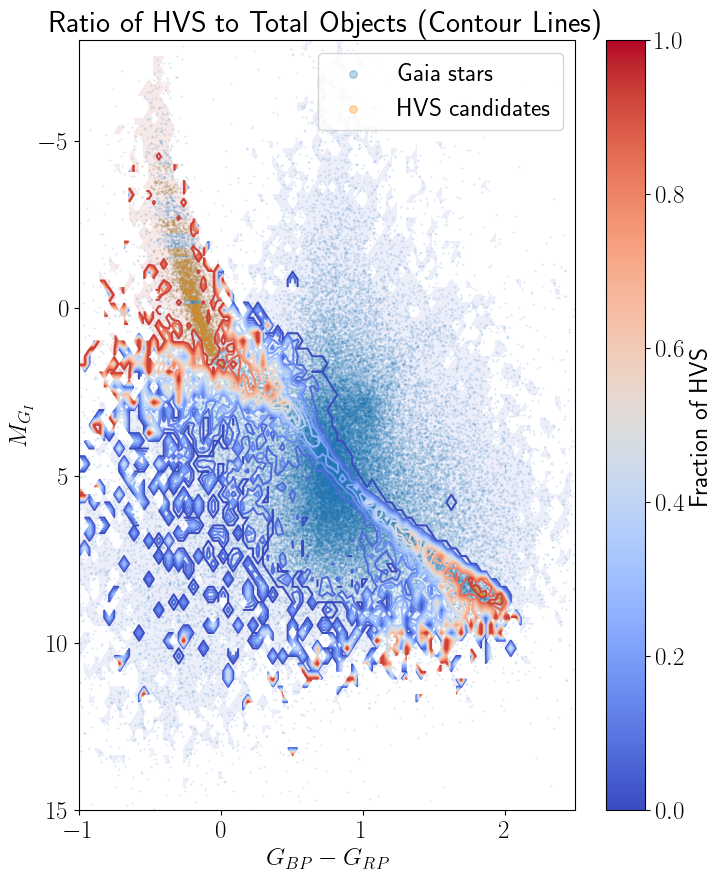

In [308]:
# Create figure
plt.figure(figsize=(8, 10))

# Define levels for the contour
contour_levels = np.linspace(0, 1, 15)

# Generate the contour plot with only lines (no filling)
X, Y = np.meshgrid(x_bins[:-1], y_bins[:-1])  # Use bin edges for meshgrid
contour_lines = plt.contour(X, Y, ratio_hist.T, levels=contour_levels, cmap='coolwarm', vmin=0, vmax=1)

contour_filled_2 = plt.contourf(X, Y, ratio_hist.T, levels=contour_levels, cmap='coolwarm', vmin=0, vmax=1, alpha = 0.1)

# Create a continuous colorbar based on the contour levels
# Create a normalizer to map the contour levels to colors
norm = mcolors.Normalize(vmin=0, vmax=1)

# Create a scalar mappable for the colorbar without displaying filled contours
sm = cm.ScalarMappable(norm=norm, cmap='coolwarm')

# Add a colorbar based on the scalar mappable
plt.colorbar(sm, label='Fraction of HVS', ax=plt.gca())


plt.scatter(data_gaia_big['bp_rp_corr'], data_gaia_big['implied_M_g_corr'], s=0.1, alpha=0.3, label = 'Gaia stars')
plt.scatter(filtered_df['bp_rp_corr'], filtered_df['implied_M_g_corr'], s=0.1, color='darkorange', alpha=0.3, label = 'HVS candidates')

# Adjust the plot
plt.gca().invert_yaxis()
plt.xlabel('$G_{BP} - G_{RP}$')
plt.ylabel('$M_{G_I}$')
plt.ylim(15, -8)
plt.xlim(-1, 2.5)
legend = plt.legend(loc= 'upper right')
# make the marker size in the legend big
for handle in legend.legend_handles:
    handle.set_sizes([30])
plt.title('Ratio of HVS to Total Objects (Contour Lines)')

plt.show()

## Paper selection for reference

In [309]:
def is_main_sequence(bp_rp, M_g):
    """
    Check if the star is in the main sequence based on the color and absolute magnitude 
    computed from the implied distance

    input:
        bp_rp: color index
        M_g: absolute magnitude

    output:
        bool: True if the star is in the main sequence

    """
    # check if the star is in the main sequence
    return np.logical_and(-1.5 < M_g - 4.3 * bp_rp, M_g - 4.3 * bp_rp < 2.5)

In [312]:
data_filtered_sill = data_gaia_big.loc[is_main_sequence(data_gaia_big['bp_rp_corr'], data_gaia_big['implied_M_g_corr'])]
data_filtered_sill = data_filtered_sill.loc[data_filtered_sill['bp_rp_corr'] < 0.5]

# print precision and recall
precision = len(data_filtered_sill.loc[data_filtered_sill['is_hvs'] == 1])/len(data_filtered_sill)
completeness = len(data_filtered_sill.loc[data_filtered_sill['is_hvs'] == 1])/len(data_hvs)

print('Using Sill method, the precision is:', precision)
print('Using Sill method, the completeness is:', completeness)

Using Sill method, the precision is: 0.7507054176072234
Using Sill method, the completeness is: 0.41066604923979316


## Using an isochrone instead of polynomial

### Machine Learning Classification

Using a catalog composed of random Gaia stars and Speedystar simulated HVS we will construct a CMD using implied distances and aparent magnitudes and colors corrected from SFD extinction

In [67]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score



### Construct normalized training sets

In [70]:
# Step 0: Create a random subset of the data
data_subset = data_gaia_big.sample(frac=0.9, random_state=42)

# Step 1: Prepare the data
X = data_subset[['bp_rp', 'implied_M_g']]
y = data_subset['is_hvs']

# Step 2: Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardizing the features (important for SVM and can benefit other classifiers)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Stochastic Gradient Descent

In [26]:
from sklearn.linear_model import SGDClassifier
svm_classifier = SGDClassifier(loss='hinge')  # hinge loss gives SVM
svm_classifier.fit(X_train_scaled, y_train)
svm_predictions = svm_classifier.predict(X_test_scaled)

# Calculating precision and recall
svm_precision = precision_score(y_test, svm_predictions)
svm_recall = recall_score(y_test, svm_predictions)
print(f"SGD, Precision: {svm_precision}, Recall: {svm_recall}")

SGD, Precision: 0.0, Recall: 0.0


### SVM linear

In [28]:
# test with a linear kernel
svm_classifier = SVC(kernel='linear', max_iter=100)
svm_classifier.fit(X_train_scaled, y_train)
svm_predictions = svm_classifier.predict(X_test_scaled)

# Calculating precision and recall
svm_precision = precision_score(y_test, svm_predictions)
svm_recall = recall_score(y_test, svm_predictions)

print(f"SVM Kernel: {'linear'}, Precision: {svm_precision}, Recall: {svm_recall}")

SVM Kernel: linear, Precision: 0.15883262114737703, Recall: 1.0


/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [58]:
# Step 3: Create and train the SVM model
# SVM kernels to evaluate
kernels = ['rbf', 'sigmoid', 'poly', 'linear']

# Loop through each kernel type, train, and evaluate the SVM
for kernel in kernels:
    svm_classifier = SVC(kernel=kernel)
    svm_classifier.fit(X_train_scaled, y_train)
    svm_predictions = svm_classifier.predict(X_test_scaled)
    
    # Calculating precision and recall
    svm_precision = precision_score(y_test, svm_predictions)
    svm_recall = recall_score(y_test, svm_predictions)
    
    print(f"SVM Kernel: {kernel}, Precision: {svm_precision}, Recall: {svm_recall}")

SVM Kernel: rbf, Precision: 0.9127134724857685, Recall: 0.4063644043931287
SVM Kernel: sigmoid, Precision: 0.12145636464702612, Recall: 0.12306392565474514
SVM Kernel: poly, Precision: 0.9432624113475178, Recall: 0.2996339059419882
SVM Kernel: linear, Precision: 0.0, Recall: 0.0


/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Since the poly seems to be the best, I will save it to a file

In [31]:
svm_classifier = SVC(kernel='poly')
svm_classifier.fit(X_train_scaled, y_train)
svm_predictions = svm_classifier.predict(X_test_scaled)

# Calculating precision and recall
svm_precision = precision_score(y_test, svm_predictions)
svm_recall = recall_score(y_test, svm_predictions)

print(f"SVM Kernel: poly, Precision: {svm_precision}, Recall: {svm_recall}")

SVM Kernel: poly, Precision: 0.9358108108108109, Recall: 0.31711505437893533


In [30]:
import joblib 
# Save the model
joblib.dump(svm_classifier, 'svm_classifier_best.pkl')

['svm_classifier_best.pkl']

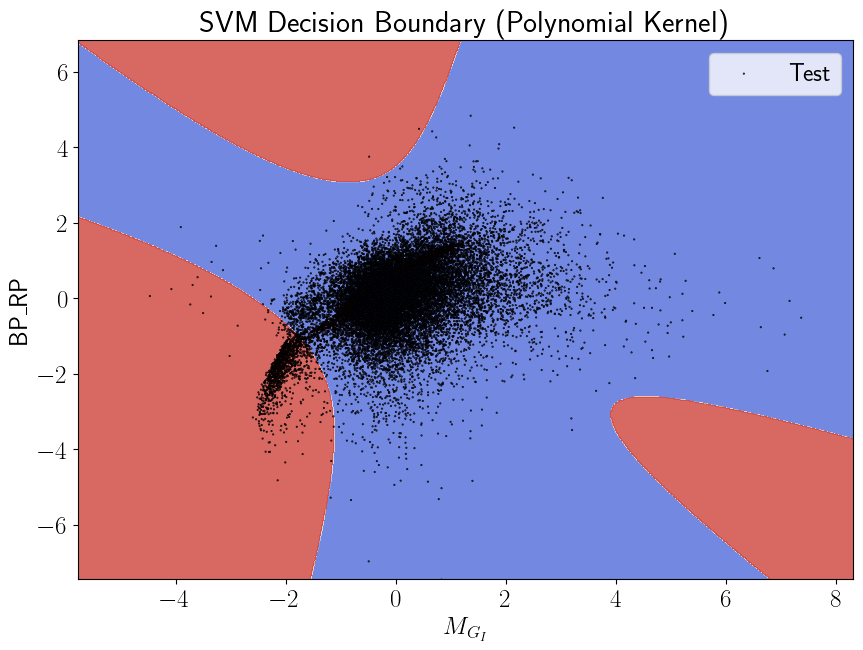

In [47]:
# plot
h = .02
x_min, x_max = X_train_scaled[:, 0].min() - 1, X_train_scaled[:, 0].max() + 1
y_min, y_max = X_train_scaled[:, 1].min() - 1, X_train_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Step 6: Predict the classifier output for each point in the mesh
Z = svm_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)



In [ ]:
# Step 7: Plot the decision boundaries and data points
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
#plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, edgecolors='k', marker='o', cmap=plt.cm.coolwarm, label='Train')
plt.scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], c=y_test, edgecolors='k', marker='.',s = 1, cmap=plt.cm.coolwarm, label='Test')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("SVM Decision Boundary (Polynomial Kernel)")
plt.xlabel('$M_{G_I}$')
plt.ylabel('BP_RP')
plt.legend()
plt.show()

/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/__/n140hqf972zfmtt1hs5ldglw0000gn/T/ipykernel_46511/2827619910.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


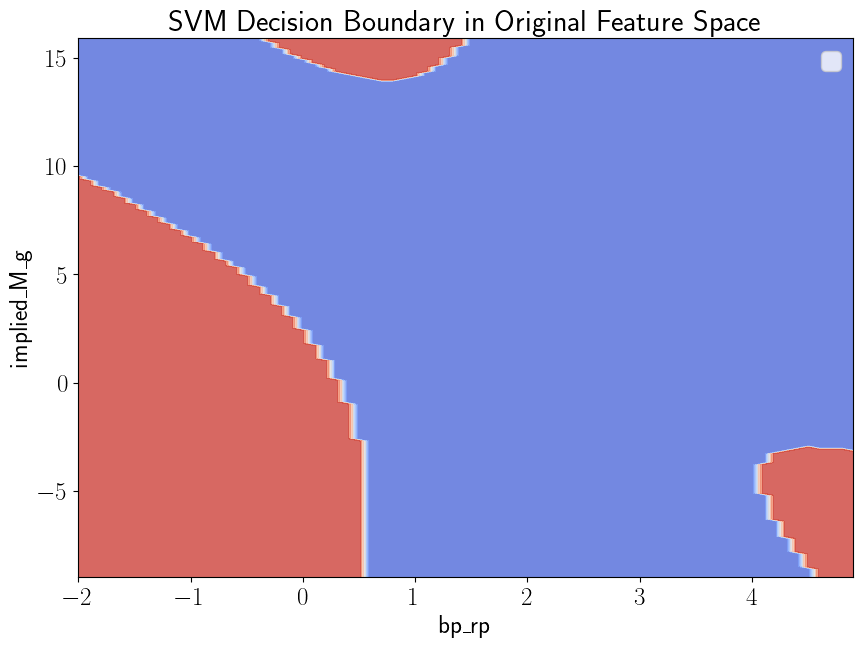

In [45]:
# Step 4: Create a mesh grid in the original data space (before scaling)
plt.ylim(15, -8)
plt.xlim(-1, 4)
h = .1  # step size in the mesh
x_min, x_max = -2,5 
y_min, y_max = -9 , 16
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


# Step 5: Rescale the mesh grid using the same scaler as the training data
mesh_grid = np.c_[xx.ravel(), yy.ravel()]
mesh_grid_scaled = scaler.transform(mesh_grid)

# Step 6: Predict the classifier output for each point in the rescaled mesh
Z = svm_classifier.predict(mesh_grid_scaled)
Z = Z.reshape(xx.shape)

# Step 7: Plot the decision boundaries and data points in the original space
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
#plt.scatter(X['bp_rp'], X['implied_M_g'], c=y, edgecolors='k', marker='o', cmap=plt.cm.coolwarm, label='Data')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("SVM Decision Boundary in Original Feature Space")
plt.xlabel('bp_rp')
plt.ylabel('implied_M_g')
plt.legend()
plt.show()

### Random Forest Classifier

In [73]:
# Creating classifier instance
rf_classifier = RandomForestClassifier(n_estimators=5000, n_jobs= -1)

# Training classifer
rf_classifier.fit(X_train, y_train)

# Predicting the test set results
rf_predictions = rf_classifier.predict(X_test)

# Calculating precision and recall
rf_precision = precision_score(y_test, rf_predictions)
rf_recall = recall_score(y_test, rf_predictions)


print("Random Forest Precision:", rf_precision, "Random Forest Recall:", rf_recall)

Random Forest Precision: 0.7456016889514426 Random Forest Recall: 0.6064682312535775


/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


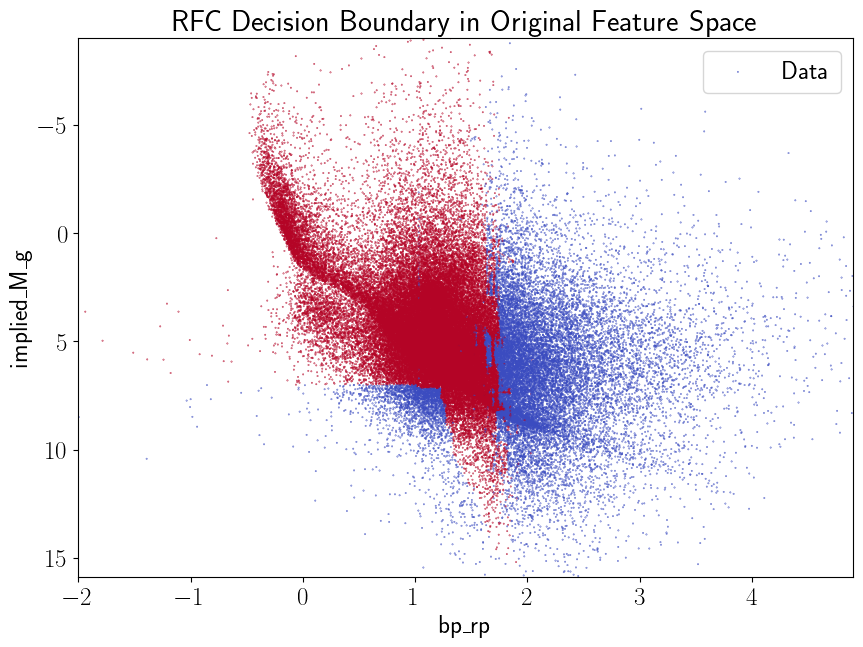

In [75]:
# Step 7: Plot the decision boundaries and data points in the original space
#plt.scatter(xx, yy, c = Z, alpha=0.8, cmap=plt.cm.coolwarm)

# Step 1: Prepare the data
X = data_subset[['bp_rp', 'implied_M_g']]
y = data_subset['is_hvs']

# Standardizing the features (important for SVM and can benefit other classifiers)
X_scaled = scaler.transform(X)
#X_scaled = scaler.transform(X)

# Predicting the test set results
rf_predictions = rf_classifier.predict(X_scaled)


plt.scatter(X['bp_rp'], X['implied_M_g'], c=rf_predictions, s = 0.1, cmap=plt.cm.coolwarm, label='Data')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("RFC Decision Boundary in Original Feature Space")
plt.xlabel('bp_rp')
plt.ylabel('implied_M_g')
plt.gca().invert_yaxis()
plt.legend()
plt.show()